## Setup autoreload, warnings and helper functions

In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, Markdown
def print_heading(string):
    display(Markdown(f"# {string}"))
def print_subheading(string):
    display(Markdown(f"## {string}"))

## Set the visibility of cuda devices (in case your system contains more than one)

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [3]:
# %cd ../..
# %ls

## Imports

In [4]:
%matplotlib inline
from config_whaleshark import config
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import zipfile
import tensorflow as tf
import wget
import pickle
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from torchvision.datasets.utils import download_url
from datasets import SimpleDataset, DatasetSlice

from tools import apply_pipeline, crop_step, curry, curry_sequential, apply_pipeline_dataset, get_save_step, apply_sequential, compose, compose_sequential
from tonemapping.tonemapping import tonemap, tonemap_step
from segmentation.segmentation import segment
from pattern_extraction.extract_pattern import extract_pattern
from pattern_extraction.extract_pattern import smart_resize
from reidentification.identify import encode_single, encode_pipeline, encode_dataset, identify, identify_single, apply_geometric
from reidentification.visualisation import visualise_match
from reidentification.find_matches import find_matches

/ekaterina/env/norppa/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-05-16 15:40:05.404134: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-05-16 15:40:07.021669: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-05-16 15:40:07.067745: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:83:00.0 name: NVIDIA TITAN RTX computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2023-05-16 15:40:07.067803: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-05-16 15:40:07.071243: I 

## Create a configuration file.
You can change the default parameters in config.py

In [5]:
cfg = config()

/ekaterina/work/src/NORPPA/repository/NORPPA/reidentification/hesaff_pytorch/architectures.py:71: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  nn.init.orthogonal(m.weight.data, gain=0.9)
/ekaterina/work/src/NORPPA/repository/NORPPA/reidentification/hesaff_pytorch/architectures.py:73: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias.data, 0.01)
2023-05-16 15:40:14.804257: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:83:00.0 name: NVIDIA TITAN RTX computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2023-05-16 15:40:14.804942: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0
2023-05-16 15:40:14.805056: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-05-16 15:4

## Download the dataset

In [6]:
print(cfg)

{'conn': <sqlite3.Connection object at 0x7f1230bebab0>, 'net': HardNet(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, mo

In [7]:
train_path = "/ekaterina/work/data/whaleshark_norppa/train"
test_path = "/ekaterina/work/data/whaleshark_norppa/test"

dataset_train = Path(train_path)
dataset_test = Path(test_path)


print(f'Whaleshark dataset is ready')

Whaleshark dataset is ready


## Create dataset variables

In [8]:
train_dataset = SimpleDataset(dataset_train)
test_dataset = SimpleDataset(dataset_test)

img_data = train_dataset[3]
print(img_data)

(<PIL.Image.Image image mode=RGB size=2400x1909 at 0x7F12307C4B90>, {'class_id': 'A-317_right', 'file': '/ekaterina/work/data/whaleshark_norppa/train/A-317_right/000000004298.jpg', 'dataset_dir': PosixPath('/ekaterina/work/data/whaleshark_norppa/train')})


## Show an image from the dataset

# Input image

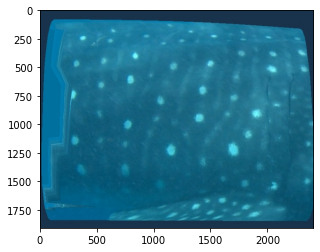

In [9]:
img, label = img_data

print_heading("Input image")
plt.imshow(img)
plt.show()

## Apply tonemapping

# Tonemapped image

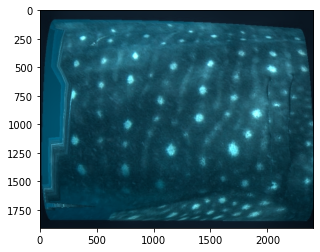

In [11]:
# Remember to install pfstmo package with
# sudo apt-get install pfstmo

tonemapped_img = tonemap(img)

print_heading("Tonemapped image")
plt.imshow(tonemapped_img)
plt.show()

## Extract pattern from an image

2023-05-16 15:47:24.881229: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-05-16 15:47:24.928081: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2700080000 Hz
2023-05-16 15:47:25.554342: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-05-16 15:47:28.136822: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2023-05-16 15:47:32.403372: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-05-16 15:47:34.895403: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


# Pattern image

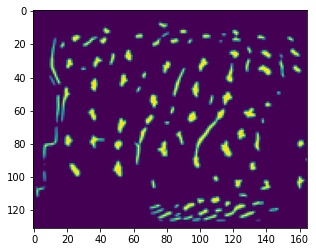

In [12]:
extract_pattern_step = curry(extract_pattern, model=cfg["unet"])

pattern_img, label = apply_pipeline(tonemapped_img, label, [extract_pattern_step])[0]

print_heading("Pattern image")
plt.imshow(pattern_img)
plt.show()

In [8]:
with open("temp/files/pattern_whaleshark.pickle", 'rb') as f_file:
    encoded_train_dataset = pickle.load(f_file)

In [13]:
cfg["topk"]=20

In [63]:
def resize_dataset(input, size):
    image, img_label = input
    if image is None:
        return [input]

    result, ratio = smart_resize(image, size, return_ratio=True)
    img_label["resize_ratio"] = ratio
    return [(result, img_label)]

In [73]:
def get_topk_matrix(identification_result):
    result = []
    for (db_labels, q_labels) in identification_result:
        q_class = q_labels['class_id']
        q_ln = len(q_labels['labels'])
        result.append([db_label['db_label']['class_id']==q_class for db_label in db_labels]*q_ln)
    return np.asarray(result)


def get_topk_accuracy(identification_result):
    result = []
    for (db_labels, q_labels) in identification_result:
        q_class = q_labels['class_id']
        q_ln = len(q_labels['labels'])
        result.append([db_label['db_label']['class_id']==q_class for db_label in db_labels]*q_ln)
    result = np.asarray(result)
    return [sum((np.sum(result[:, :j+1], axis=1) > 0)) / len(result) for j in range(result.shape[1])]

def print_topk_accuracy(identification_result, label=""):
    topk_acc = get_topk_accuracy(identification_result)
    print(label)
    for (i, acc) in enumerate(topk_acc):
        print(f"Top-{i+1} accuracy: {acc*100}%")
    return identification_result


  0%|                                                    | 0/20 [00:00<?, ?it/s]/ekaterina/env/norppa/lib/python3.7/site-packages/torch/nn/functional.py:4066: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/ekaterina/env/norppa/lib/python3.7/site-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
100%|███████████████████████████████████████████| 20/20 [00:35<00:00,  1.78s/it]
/ekaterina/work/src/NORPPA/repository/NORPPA/reidentification/identify.py:202: VisibleDeprecationWarning: Creatin

Calculating PCA
Getting encoding parameters...
Encoding...
20


100%|████████████████████████████████████████| 20/20 [00:00<00:00, 29096.80it/s]

Before geometric verification:
Top-1 accuracy: 95.0%
Top-2 accuracy: 100.0%
Top-3 accuracy: 100.0%
Top-4 accuracy: 100.0%
Top-5 accuracy: 100.0%
Top-6 accuracy: 100.0%
Top-7 accuracy: 100.0%
Top-8 accuracy: 100.0%
Top-9 accuracy: 100.0%
Top-10 accuracy: 100.0%
Top-11 accuracy: 100.0%
Top-12 accuracy: 100.0%
Top-13 accuracy: 100.0%
Top-14 accuracy: 100.0%
Top-15 accuracy: 100.0%
Top-16 accuracy: 100.0%
Top-17 accuracy: 100.0%
Top-18 accuracy: 100.0%
Top-19 accuracy: 100.0%
Top-20 accuracy: 100.0%



/ekaterina/work/src/NORPPA/repository/NORPPA/reidentification/identify.py:278: RuntimeWarning: invalid value encountered in true_divide
  similarity = (np.max(sorted_dists) - sorted_dists) / np.max(sorted_dists)
/ekaterina/work/src/NORPPA/repository/NORPPA/reidentification/geometric.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for qr_patches in qr_patches_all])
/ekaterina/work/src/NORPPA/repository/NORPPA/reidentification/geometric.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for db_patches in db_patches_all])


After geometric verification:
Top-1 accuracy: 100.0%
Top-2 accuracy: 100.0%
Top-3 accuracy: 100.0%
Top-4 accuracy: 100.0%
Top-5 accuracy: 100.0%
Top-6 accuracy: 100.0%
Top-7 accuracy: 100.0%
Top-8 accuracy: 100.0%
Top-9 accuracy: 100.0%
Top-10 accuracy: 100.0%
Top-11 accuracy: 100.0%
Top-12 accuracy: 100.0%
Top-13 accuracy: 100.0%
Top-14 accuracy: 100.0%
Top-15 accuracy: 100.0%
Top-16 accuracy: 100.0%
Top-17 accuracy: 100.0%
Top-18 accuracy: 100.0%
Top-19 accuracy: 100.0%
Top-20 accuracy: 100.0%


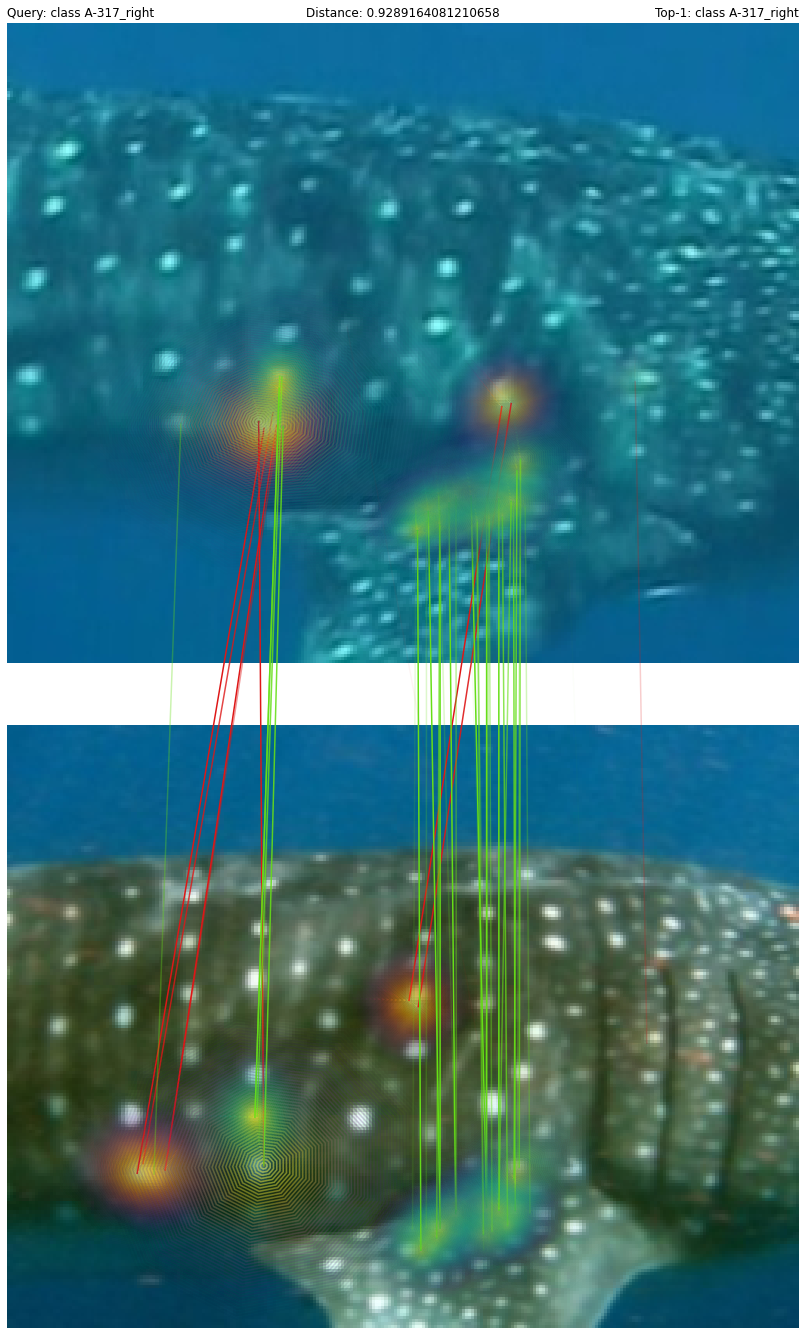

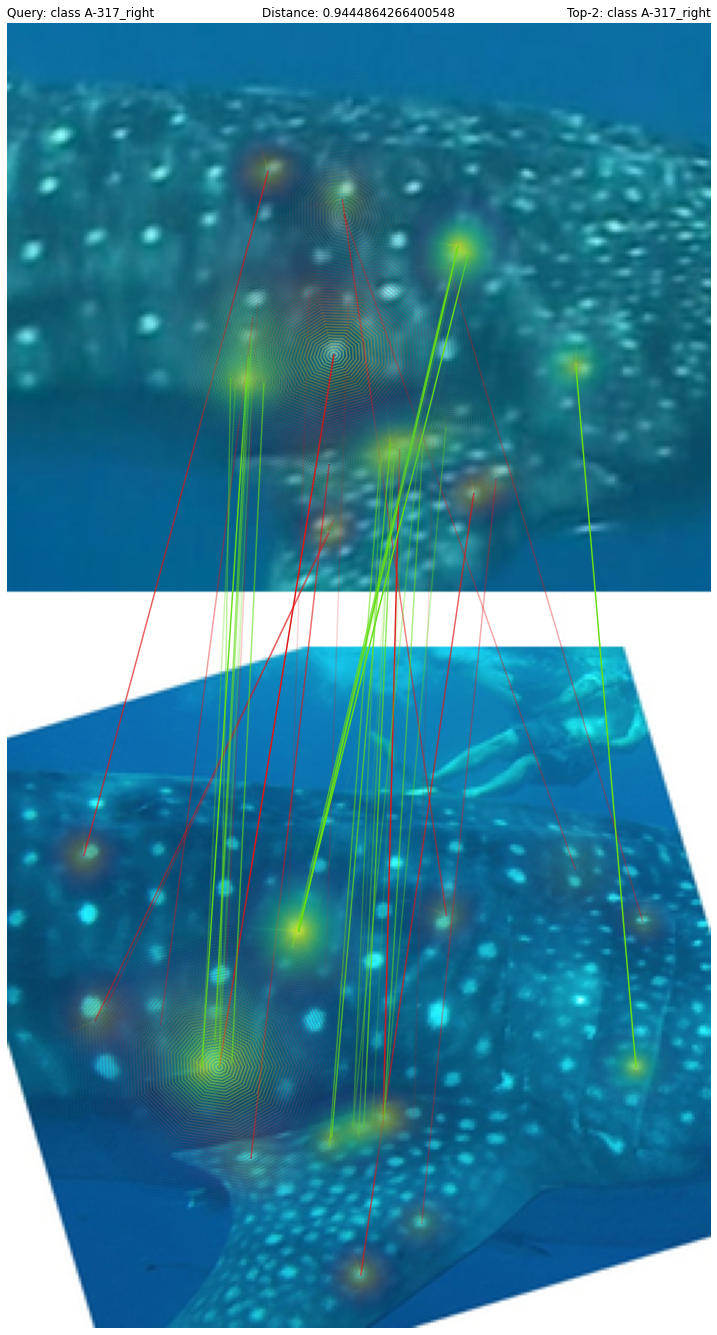

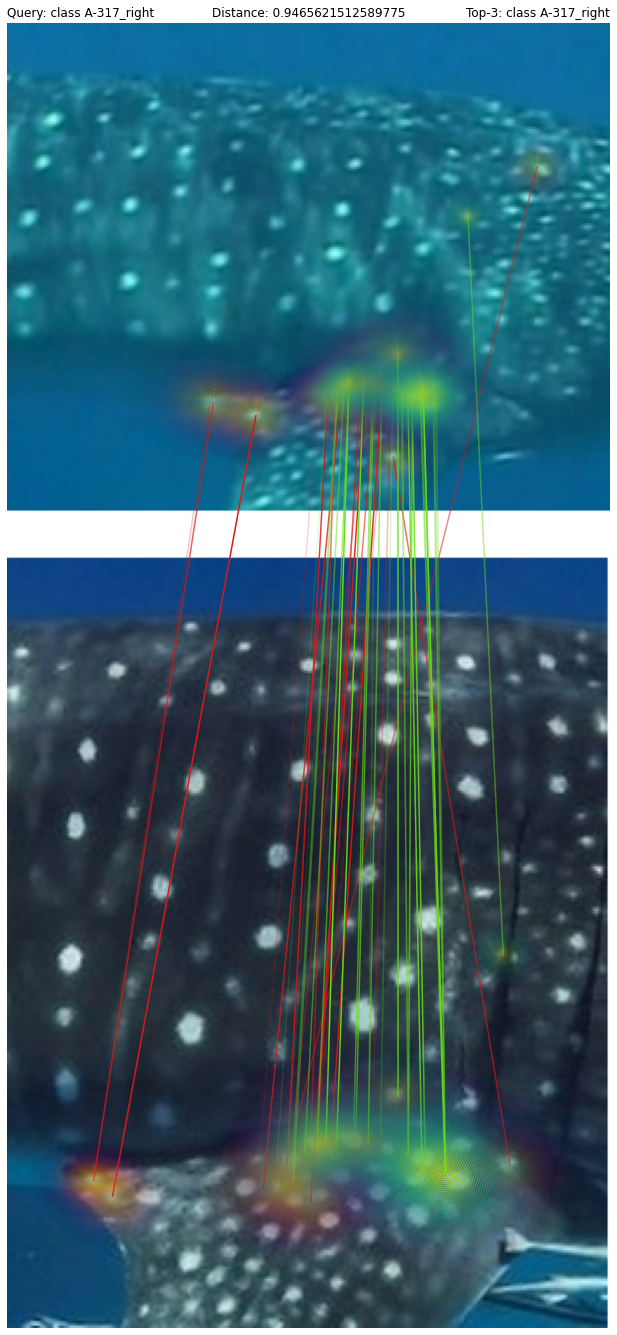

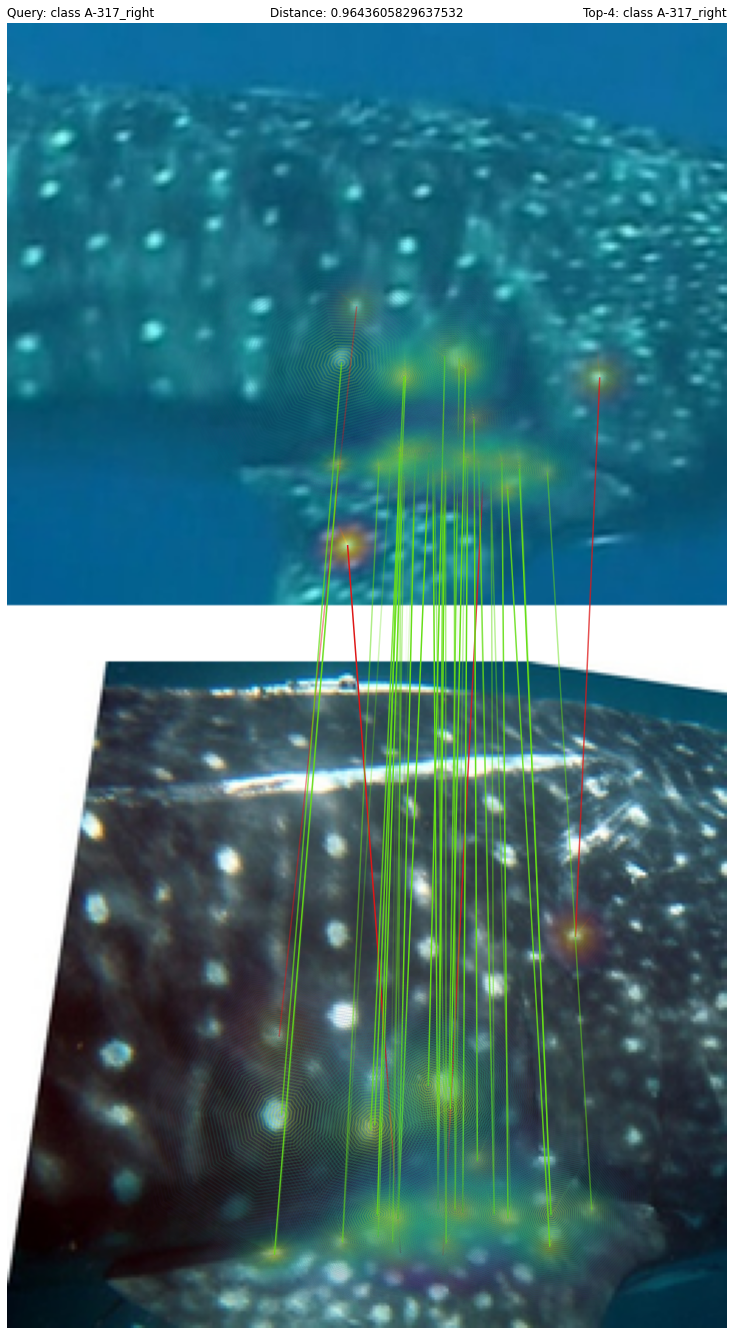

KeyboardInterrupt: 

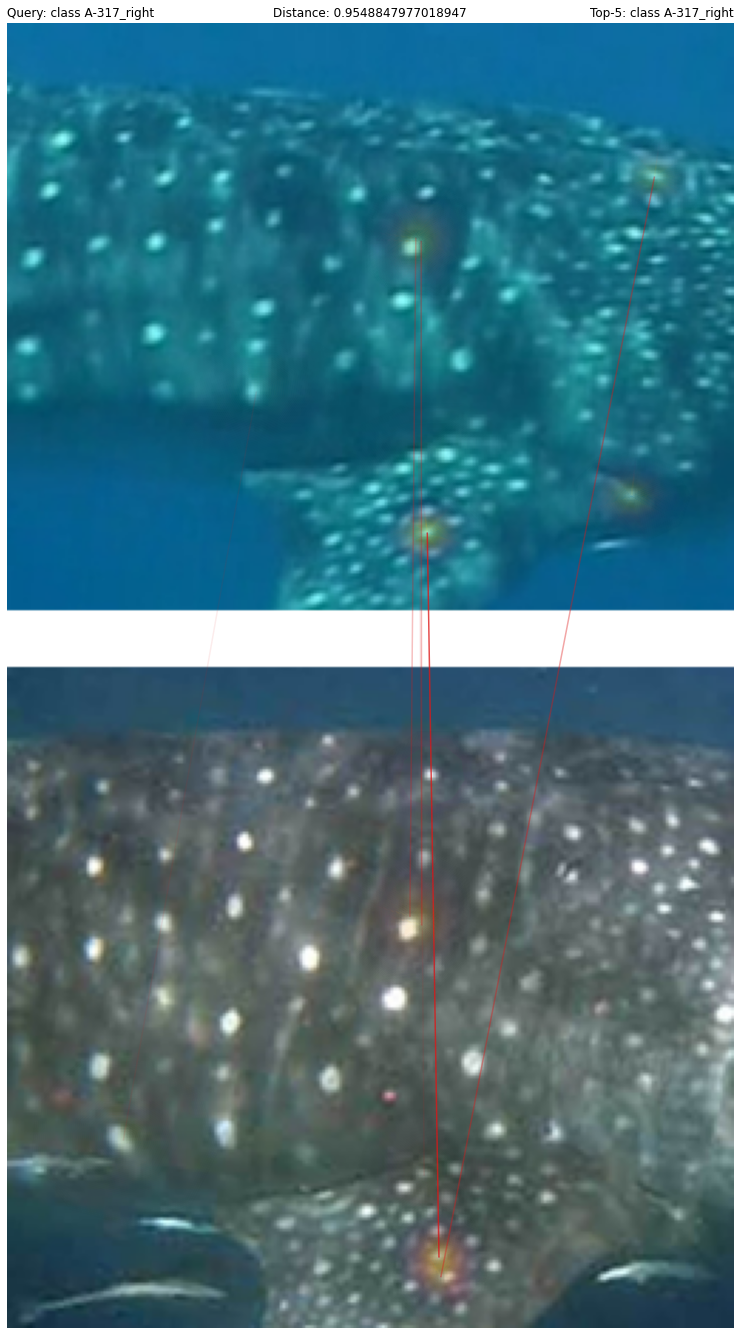

In [75]:
encode_pipeline = [
    curry_sequential(resize_dataset, 256),
    curry(encode_dataset, cfg=cfg)
]
test_dataset_mini = DatasetSlice(test_dataset, range(5))
train_dataset_mini = DatasetSlice(train_dataset, range(20))
encoded_train_dataset = apply_pipeline_dataset(train_dataset_mini, pipeline)

# test_pipeline = [
#                  curry(identify, encoded_train_dataset, cfg["topk"]),
#                  curry_sequential(find_matches, cfg),
#                  curry_sequential(apply_geometric, cfg["geometric"]),
#                  curry_sequential(visualise_match, cfg["topk"])
#                 ]

# encoded_test_dataset = apply_pipeline_dataset(test_dataset_mini, encode_pipeline + test_pipeline)

test_pipeline = [
                 curry(identify, encoded_train_dataset, cfg["topk"], leave_one_out=True),
                 curry(print_topk_accuracy, label="Before geometric verification:"),
                 curry_sequential(find_matches, cfg),
                 curry_sequential(apply_geometric, cfg["geometric"]),
                 curry(print_topk_accuracy, label="After geometric verification:"),
                 curry_sequential(visualise_match, cfg["topk"])
                ]

apply_pipeline_dataset(encoded_train_dataset, test_pipeline)
None

In [36]:
# reevaluated = curry_sequential(apply_geometric, cfg["geometric"])(encoded_test_dataset)

In [49]:
# reevaluated[0][0][0]['Mask'].squeeze()
# np.full(5, True)

array([ True,  True,  True,  True,  True])

In [ ]:
visualise_match(encoded_test_dataset[0], cfg["topk"])
# encoded_test_dataset[0][0]

In [15]:
with open("temp/files/orig_whaleshark.pickle", 'wb') as f_file:
    pickle.dump(encoded_train_dataset, f_file)

In [17]:
print(len(encoded_train_dataset))

30


In [18]:
def resize_dataset(input, size):
    image, img_label = input
    if image is None:
        return [input]

    result = smart_resize(image, size)
    
    return [(result, img_label)]

In [13]:
pipeline = [
#     curry_sequential(resize_dataset, 256),
    curry(encode_dataset, cfg=cfg)
]

train_dataset_mini = DatasetSlice(train_dataset, range(0, 2))
encoded_mini = apply_pipeline_dataset(train_dataset_mini, pipeline)


  0%|                                                     | 0/2 [00:00<?, ?it/s]/ekaterina/env/norppa/lib/python3.7/site-packages/torch/nn/functional.py:4066: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/ekaterina/env/norppa/lib/python3.7/site-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
100%|█████████████████████████████████████████████| 2/2 [00:05<00:00,  2.94s/it]
/ekaterina/work/src/NORPPA/repository/NORPPA/reidentification/identify.py:198: VisibleDeprecationWarning: Creatin

Calculating PCA
Getting encoding parameters...
Encoding...


In [14]:

identification_result = identify(encoded_mini, encoded_mini, cfg["topk"], leave_one_out=True)

100%|██████████████████████████████████████████| 2/2 [00:00<00:00, 14614.30it/s]


In [61]:
cfg["topk"]=20

## Perform re-identification

In [17]:
identification_result = identify(encoded_train_dataset, encoded_train_dataset, cfg["topk"],leave_one_out=True)

20


100%|████████████████████████████████████| 5409/5409 [00:00<00:00, 11289.40it/s]


In [18]:
def get_topk_matrix(identification_result):
    result = []
    for (db_labels, q_labels) in identification_result:
        q_class = q_labels['class_id']
        q_ln = len(q_labels['labels'])
        result.append([db_label['db_label']['class_id']==q_class for db_label in db_labels]*q_ln)
    return np.asarray(result)

topk_matrix = get_topk_matrix(identification_result)
print(len(topk_matrix))
# print(topk_matrix)
        

topk = 5
hits = topk_matrix 
# hits = (db_labels.T == q_labels).T
print([sum((np.sum(hits[:, :j+1], axis=1) > 0)) / len(topk_matrix)
        for j in range(topk)])

5409
[0.4559068219633943, 0.519134775374376, 0.5546311702717692, 0.582547605842115, 0.6073211314475874]


In [19]:
pipeline = [curry_sequential(find_matches, cfg)]
matches = apply_pipeline_dataset(identification_result, pipeline, verbose=True)

Completed 1/1 steps


In [20]:
pipeline = [curry_sequential(apply_geometric, cfg["geometric"])]
reevaluated = apply_pipeline_dataset(matches, pipeline, verbose=True)


Completed 1/1 steps


In [21]:


topk_matrix = get_topk_matrix(reevaluated)
print(len(topk_matrix))
# print(topk_matrix)
        

topk = 5
hits = topk_matrix 
# hits = (db_labels.T == q_labels).T
print([sum((np.sum(hits[:, :j+1], axis=1) > 0)) / len(topk_matrix)
        for j in range(topk)])

5409
[0.5925309669070068, 0.6365317064152338, 0.661859863190978, 0.6786836753558884, 0.6901460528748382]


In [1]:
dataset_slice = DatasetSlice(identification_result, range(0, 20))
visualisation_step = curry(visualise_match, cfg=cfg)
pipeline = [
    apply_sequential(visualisation_step)
]

identification_result = apply_pipeline_dataset(identification_result, pipeline,verbose=True)

NameError: name 'DatasetSlice' is not defined

## Visualise re-identification results

In [ ]:
visualise_match(identification_result[0])
# print()

## Apply full pipeline to another query image

In [34]:
full_pipeline = [
            tonemap_step, 
            segment_step, crop_step,
            extract_pattern_step,
            curry(encode_pipeline, cfg=cfg),
            curry(identify_single, database=simple_db, cfg=cfg),
            visualise_match
            ]

apply_pipeline(*query_dataset[0], full_pipeline)
print()

NameError: name 'segment_step' is not defined

## Applying many-to-one

In [89]:

pipeline = [apply_sequential(tonemap_step), 
            apply_sequential(segment_step),
            apply_sequential(crop_step),
            apply_sequential(extract_pattern_step),
            curry(encode_dataset, cfg=cfg),
            curry(identify, database=simple_db, cfg=cfg)
            ]

result = apply_pipeline_dataset(query_dataset[:2], pipeline)

# encoded_sequence = encode_sequence_dataset(pattern_query_dataset, cfg)


TypeError: stat: path should be string, bytes, os.PathLike or integer, not tuple

In [95]:
print(segmented_query_dataset[:2])

TypeError: stat: path should be string, bytes, os.PathLike or integer, not tuple

In [27]:


print([i[1] for i in segmented_query_dataset.data])
print(segmented_query_dataset.classes)

['1', '1', '1', '1', '1', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '14', '14', '14', '14', '14', '14', '14', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '21', '22', '22', '22', '22', '22', '22', '22', '22', '22', '22', '22', '22', '22', '22', '22', '22', '22', '22', '22', '22'

In [73]:
from reidentification.identify import group_by

In [75]:
ids, labels = group_by(segmented_query_dataset, 'file')

In [76]:
print(ids)
print(labels)

[1394, 784, 1237, 398, 278, 178, 1173, 171, 775, 302, 824, 1, 747, 284, 247, 698, 1618, 726, 384, 1156, 1083, 1115, 888, 838, 1163, 1158, 34, 1082, 1477, 1411, 376, 1393, 188, 725, 1142, 751, 1401, 774, 519, 202, 1315, 505, 770, 957, 1389, 510, 46, 604, 1132, 341, 847, 696, 1405, 1196, 435, 553, 90, 703, 1081, 1151, 1399, 1016, 793, 468, 1309, 1625, 513, 1148, 1098, 1359, 484, 1124, 1489, 759, 406, 448, 528, 1542, 486, 318, 637, 1486, 1250, 693, 630, 1494, 685, 1262, 1194, 662, 701, 1628, 1149, 1438, 449, 851, 497, 1483, 1105, 919, 261, 815, 779, 738, 287, 288, 525, 1620, 728, 144, 1009, 1469, 1164, 552, 1189, 1383, 932, 1474, 300, 845, 1183, 555, 1566, 1230, 901, 1297, 1318, 1032, 970, 538, 1632, 130, 925, 654, 124, 240, 1096, 1482, 485, 1497, 1641, 442, 868, 1423, 317, 911, 469, 473, 1528, 1426, 320, 504, 570, 299, 937, 755, 1586, 359, 133, 1564, 1023, 1349, 345, 1054, 1480, 641, 1631, 218, 1520, 1602, 1174, 913, 758, 499, 712, 1476, 879, 1370, 342, 1406, 154, 334, 1531, 1145, 502, 1